Based on: https://strike.scec.org/cvws/seas/download/SEAS_BP1_QD.pdf
And: https://strike.scec.org/cvws/seas/download/apr23_2018/Erickson-Jiang_Benchmark_results_and_discussions.pdf

Goals:
- email SEAS people to get a time series for one of the backslip models
- make another version that also includes a viscoelastic layer!
- probable issues with the fault tip:
    - debug the weird wavyness I'm seeing in the comparison with Junle Jiang's results from SEAS
      - three possibilities:
        - it's a real difference in methodology and the discrepancy would vanish when comparing against another true antiplane BIE implementation
        - it's caused by the runge kutta integration not being sufficiently good for this problem.
        - it's caused by a more fundamental bug, possibly the fault tip singularity influencing the solution?
    - debug the crazyness that happens when I increase to 16th order panels.
      - this probably happens because the timestepping starts having trouble when the spacing between nodes is too small. With 16th order elements, the spacing between nodes will be way too small.

In [2]:
from tectosaur2.nb_config import setup

setup()

## Quasidynamic rupture on an fault in an antiplane half space

In the previous section, we built the infrastructure for solving for displacement and stress everyone in the domain given slip on a fault in an antiplane half space. This time, we'll go a step further and simulate rate and state friction and slip on that fault.

In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term
from tectosaur2.laplace2d import double_layer, hypersingular

In [4]:
surf_half_L = 10000000
fault_bottom = 40000
max_panel_length = 100
shear_modulus = 3.2e10

qx, qw = gauss_rule(5)
t = sp.var("t")

control_points = [
    (0, -fault_bottom / 2, fault_bottom / 2, max_panel_length),
    (0, 0, fault_bottom * 3, max_panel_length * 2)
]
fault, free = refine_surfaces(
    [
        (t, t * 0, fault_bottom * (t + 1) * -0.5),  # fault
        (t, -t * surf_half_L, 0 * t),  # free surface
    ],
    (qx, qw),
    control_points=control_points,
)
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The free surface mesh has 1626 panels with a total of 8130 points.
The fault mesh has 448 panels with a total of 2240 points.


In [5]:
singularities = np.array(
    [
        [-surf_half_L, 0],
        [surf_half_L, 0],
        [0, 0],
        [0, -fault_bottom],
    ]
)

(free_disp_to_free_disp, fault_slip_to_free_disp), report = integrate_term(
    double_layer, free.pts, free, fault, singularities=singularities, return_report=True
)
fault_slip_to_free_disp = fault_slip_to_free_disp[:, 0, :]
free_disp_solve_mat = (
    np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp[:, 0, :]
)
free_disp_solve_mat_inv = np.linalg.inv(free_disp_solve_mat)

(free_disp_to_fault_stress, fault_slip_to_fault_stress), report = integrate_term(
    hypersingular,
    fault.pts,
    free,
    fault,
    singularities=singularities,
    return_report=True,
)
fault_slip_to_fault_stress *= shear_modulus
free_disp_to_fault_stress *= shear_modulus

fault_slip_to_fault_traction = np.sum(
    fault_slip_to_fault_stress * fault.normals[:, :, None], axis=1
)
free_disp_to_fault_traction = np.sum(
    free_disp_to_fault_stress * fault.normals[:, :, None], axis=1
)

max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!
max fail!


/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:141: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:147: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


In [6]:
A = fault_slip_to_fault_traction
B = free_disp_to_fault_traction
C = fault_slip_to_free_disp
Dinv = free_disp_solve_mat_inv
total_fault_slip_to_fault_traction = A - B.dot(Dinv.dot(C))

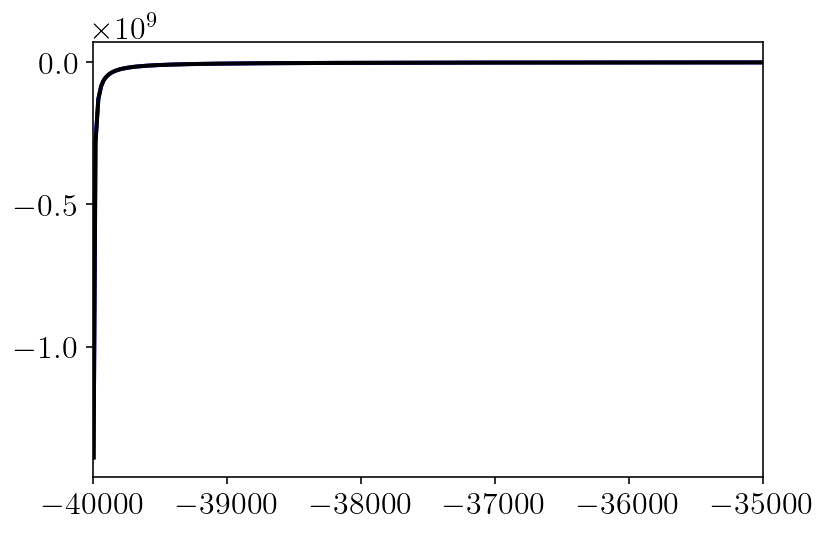

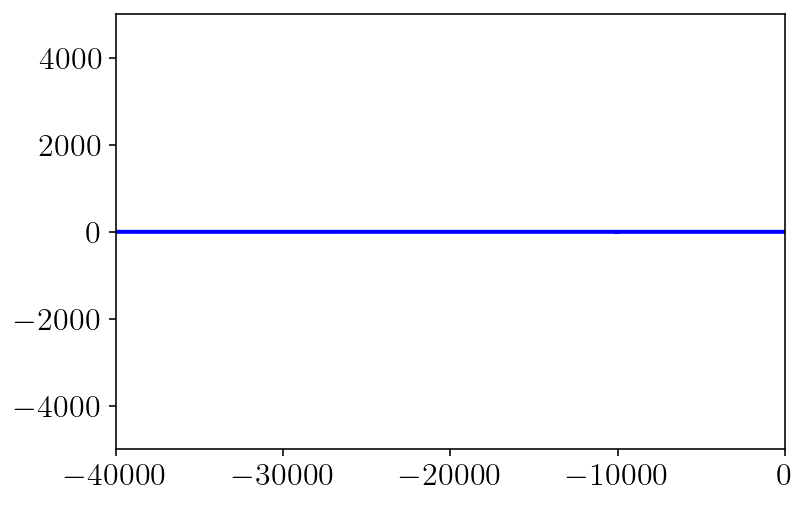

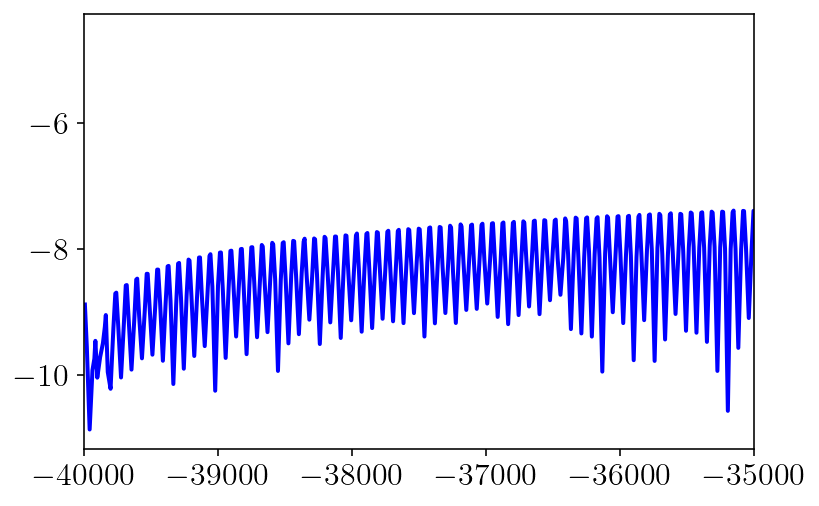

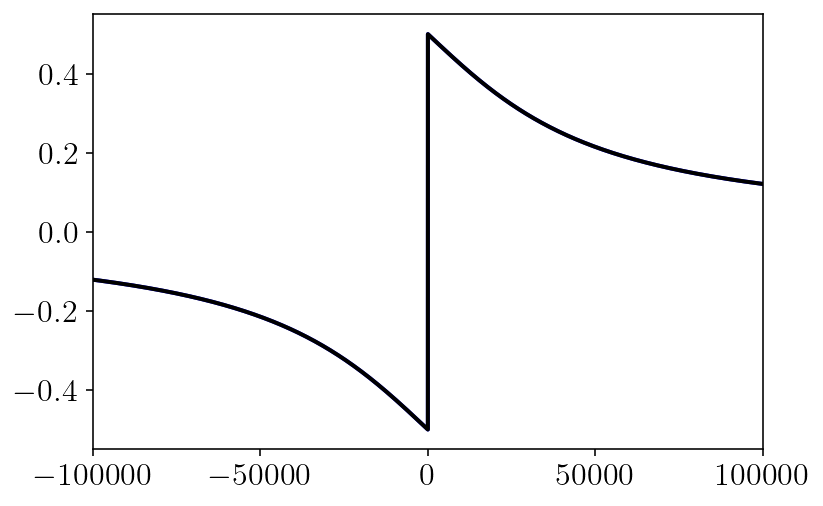

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_3406/192240783.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.plot(free.pts[:,0], np.log10(np.abs(numerical_sd - analytical_sd)), 'b-')


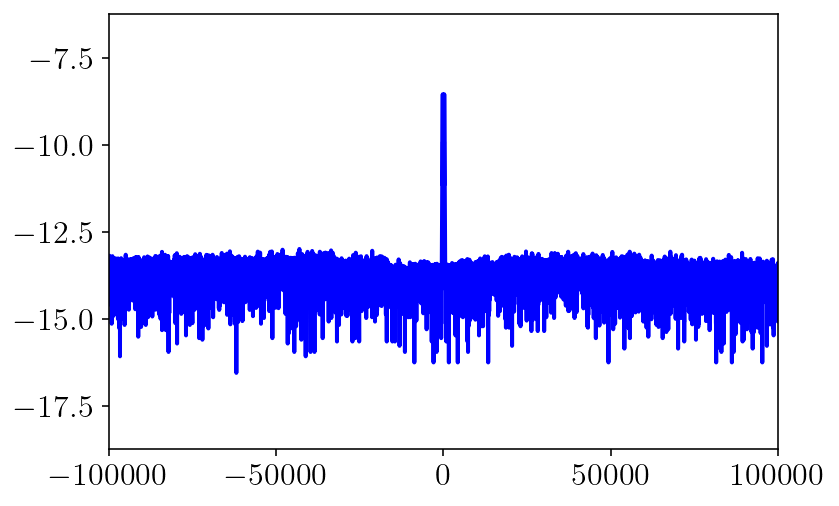

In [7]:
analytical_sd = -np.arctan(-fault_bottom / free.pts[:,0]) / np.pi
numerical_sd = free_disp_solve_mat_inv.dot(-fault_slip_to_free_disp).sum(axis=1)
rp = (fault.pts[:,1] + 1) ** 2
analytical_ft = -(shear_modulus / (2 * np.pi)) * ((1.0 / (fault.pts[:,1] + fault_bottom)) - (1.0 / (fault.pts[:,1] - fault_bottom)))
numerical_ft = total_fault_slip_to_fault_traction.sum(axis=1)
plt.plot(fault.pts[:,1], analytical_ft, 'b-')
plt.plot(fault.pts[:,1], numerical_ft, 'k-')
plt.xlim([-fault_bottom, -35000])
plt.show()
plt.plot(fault.pts[:,1], numerical_ft - analytical_ft, 'b-')
plt.xlim([-fault_bottom, 0])
plt.ylim([-5000, 5000])
plt.show()
plt.plot(fault.pts[:,1], np.log10(np.abs((numerical_ft - analytical_ft)/(analytical_ft))), 'b-')
plt.xlim([-fault_bottom, -35000])
plt.show()
plt.plot(free.pts[:,0], analytical_sd, 'b-')
plt.plot(free.pts[:,0], numerical_sd, 'k-')
plt.xlim([-100000, 100000])
plt.show()
plt.plot(free.pts[:,0], np.log10(np.abs(numerical_sd - analytical_sd)), 'b-')
plt.xlim([-100000, 100000])
plt.show()

$$
\int_{H} H^* u + \int_{F} H^* s = t
$$
$$
u + \int_{H} T^* u + \int_{F} T^* s = 0
$$

Copy the derivation on my whiteboard

## Rate and state friction

In [8]:
from dataclasses import dataclass

In [9]:
@dataclass
class FrictionParams:
    a: np.ndarray
    b: float
    V0: float
    Dc: float
    f0: float

In [10]:
siay = 31556952
density = 2670  # rock density (kg/m^3)
cs = np.sqrt(shear_modulus / density)  # Shear wave speed (m/s)
eta = shear_modulus / (2 * cs)  # The radiation damping coefficient (kg / (m^2 * s))
Vp = 1e-9  # Rate of plate motion
sigma_n = 50e6  # Normal stress (Pa)

a0 = 0.01
amax = 0.025
fy = fault.pts[:, 1]
H = 15000
h = 3000
a = np.where(
    fy > -H, a0, np.where(fy > -(H + h), a0 + (amax - a0) * (fy + H) / -h, amax)
)

fp = FrictionParams(
    a=a,  # direct velocity strengthening effect
    b=0.015,  # state-based velocity weakening effect
    Dc=0.008,  # state evolution length scale (m)
    f0=0.6,  # baseline coefficient of friction
    V0=1e-6,  # when V = V0, f = f0, V is (m/s)
)

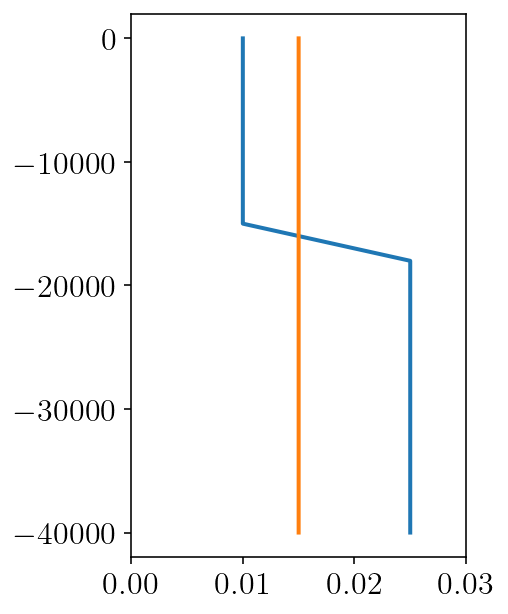

In [11]:
plt.figure(figsize=(3, 5))
plt.plot(fp.a, fy)
plt.plot(np.full(fy.shape[0], fp.b), fy)
plt.xlim([0, 0.03])
plt.show()

In [12]:
def aging_law(fp, V, state):
    return (fp.b * fp.V0 / fp.Dc) * (np.exp((fp.f0 - state) / fp.b) - (V / fp.V0))

In [13]:
def F(fp, V, state):
    return sigma_n * fp.a * np.arcsinh(V / (2 * fp.V0) * np.exp(state / fp.a))


def dFdV(fp, V, state):
    expsa = np.exp(state / fp.a)
    Q = (V * expsa) / (2 * fp.V0)
    return fp.a * expsa * sigma_n / (2 * fp.V0 * np.sqrt(1 + Q * Q))

In [14]:
def qd_equation(fp, shear_stress, V, state):
    return shear_stress - eta * V - F(fp, V, state)


def qd_equation_dV(fp, V, state):
    return -eta - dFdV(fp, V, state)


def rate_state_solve_old(fp, shear, V_old, state, tol=1e-10, V_min=1e-30):
    def qd(V):
        return qd_equation(fp, shear, V, state)

    def qd_dV(V):
        return qd_equation_dV(fp, V, state)

    V = V_old
    max_iter = 150
    for i in range(max_iter):
        f = qd_equation(fp, shear, V, state)
        dfdv = qd_equation_dV(fp, V, state)
        Vn = np.maximum(V - (f / dfdv), V_min)
        if np.max(np.abs(V - Vn) / np.minimum(Vn, V)) < tol:
            break
        V = Vn
        if i == max_iter - 1:
            raise Exception("Failed to converge.")
    return Vn

In [15]:
%load_ext cython

In [16]:
%%cython --verbose
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport asinh, exp, sqrt, fabs, fmax, fmin

def rate_state_solve(
    fp, double sigma_n, double eta, 
    double[::1] shear, double[::1] V_old, double[::1] state, 
    int max_iter=100, double tol=1e-10, double V_min=1e-30
):
    cdef double[::1] fp_a = fp.a
    cdef double fp_b = fp.b
    cdef double fp_V0 = fp.V0
    
    cdef int n = shear.shape[0]
    cdef out_V = np.empty(n, dtype=np.float64)
    cdef double[::1] V = out_V
    
    cdef int i, j
    cdef double F, dFdV, qd_eqtn, Q, qd_eqtn_dV, V_tmp, sigma_F, expsa
    cdef bint failed = False
    
    # We don't parallelize here because the small problems here have more 
    # parallelization overhead than speedup.
    for j in range(n):
        V[j] = V_old[j]
        expsa = exp(state[j] / fp_a[j]) / (2 * fp_V0)
        sigma_F = sigma_n * fp_a[j]
        for i in range(max_iter):
            Q = V[j] * expsa
            F = sigma_F * asinh(Q)
            qd_eqtn = shear[j] - eta * V[j] - F
    
            dFdV = sigma_F * expsa / sqrt(1 + Q * Q)
            qd_eqtn_dV = -eta - dFdV
            
            V_tmp = V[j]
            V[j] = fmax(V[j] - qd_eqtn / qd_eqtn_dV, V_min)
            if fabs(V[j] - V_tmp) / fmin(V[j], V_tmp) < tol:
                break
            if i == max_iter - 1:
                print(V[j], V_tmp)
                failed = True
                
    if failed == 1:
        raise Exception(f"Rate-state Newton failed to converge in {max_iter} iterations.")
    return out_V

In [17]:
shear = np.full(fault.n_pts, 30e6)
V = np.full(fault.n_pts, Vp)
state = np.full(fault.n_pts, 0.7)


def benchmark():
    for i in range(300):
        rate_state_solve(fp, sigma_n, eta, shear, V, state)
        #rate_state_solve_old(fp, shear, V, state)
benchmark()

In [18]:
%%time
benchmark()

CPU times: user 228 ms, sys: 1.29 ms, total: 229 ms
Wall time: 229 ms


In [19]:
V1 = rate_state_solve(fp, sigma_n, eta, shear, V, state)
V2 = rate_state_solve_old(fp, shear, V, state)

np.any(V1 - V2 > 1e-20)

False

## Quasidynamic earthquake cycle derivatives

In [20]:
from scipy.optimize import fsolve
import copy

fp_amax = copy.deepcopy(fp)
fp_amax.a = amax

init_state_scalar = fsolve(lambda S: aging_law(fp, Vp, S), 0.7)[0]
init_state = np.full(fault.n_pts, init_state_scalar)
tau_amax = F(fp_amax, Vp, init_state_scalar) + eta * Vp
init_traction = np.full(fault.n_pts, tau_amax)

In [21]:
init_slip_deficit = np.zeros(fault.n_pts)
init_conditions = np.concatenate((init_slip_deficit, init_state))

In [34]:
def calc_system_state(t, y, verbose=False):
    if verbose:
        print(t)
        print(t)
        print(t)
        print(t)
        print(t)

    slip_deficit = y[: init_slip_deficit.shape[0]]
    state = y[init_slip_deficit.shape[0] :]

    if np.any((state < 0) | (state > 1.2)):
        return False

    tau_qs = init_traction - total_fault_slip_to_fault_traction.dot(slip_deficit)

    try:
        V = rate_state_solve(fp, sigma_n, eta, tau_qs, calc_system_state.V_old, state)
    except RuntimeError:
        return False
    if not np.all(np.isfinite(V)):
        return False
    calc_system_state.V_old = V

    dstatedt = aging_law(fp, V, state)

    slip_deficit_rate = Vp - V
    out = slip_deficit, state, tau_qs, V, slip_deficit_rate, dstatedt
    if verbose:
        plot_system_state(out)

    return out


calc_system_state.V_old = np.full(fault.n_pts, Vp)


def plot_system_state(SS):
    slip_deficit, state, tau_qs, slip_deficit_rate, dstatedt = SS

    plt.figure(figsize=(15, 9))
    plt.subplot(2, 3, 1)
    plt.title("slip")
    plt.plot(fault.pts[:, 1], slip_deficit)

    plt.subplot(2, 3, 2)
    plt.title("state")
    plt.plot(fault.pts[:, 1], state)

    plt.subplot(2, 3, 3)
    plt.title("tau qs")
    plt.plot(fault.pts[:, 1], tau_qs)

    plt.subplot(2, 3, 4)
    plt.title("slip rate")
    plt.plot(fault.pts[:, 1], slip_deficit_rate)

    plt.subplot(2, 3, 6)
    plt.title("dstatedt")
    plt.plot(fault.pts[:, 1], dstatedt)
    plt.tight_layout()

    plt.show()


def calc_derivatives(t, y):
    # print('trying', t / siay)
    if not np.all(np.isfinite(y)):
        return np.inf * y
    state = calc_system_state(t, y)  # , verbose=True)
    if not state:
        return np.inf * y
    calc_derivatives.state = state
    derivatives = np.concatenate((state[-2], state[-1]))
    return derivatives

## Integrating through time

In [35]:
mesh_L = np.max(np.abs(np.diff(fault.pts[:, 1])))
Lb = shear_modulus * fp.Dc / (sigma_n * fp.b)
hstar = (np.pi * shear_modulus * fp.Dc) / (sigma_n * (fp.b - fp.a))
mesh_L, Lb, np.min(hstar[hstar > 0])

(42.06791485200665, 341.3333333333333, 3216.990877275949)

In [211]:
np.min(max_dt_ratio)

0.16519096075062784

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_3406/525088666.py:1: RuntimeWarning: invalid value encountered in sqrt
  2 / (-0.5 * rho - np.sqrt(chi))


array([nan, nan, nan, ..., nan, nan, nan])

/Users/tbent/.miniforge3/envs/tectosaur2/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tbent/.miniforge3/envs/tectosaur2/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


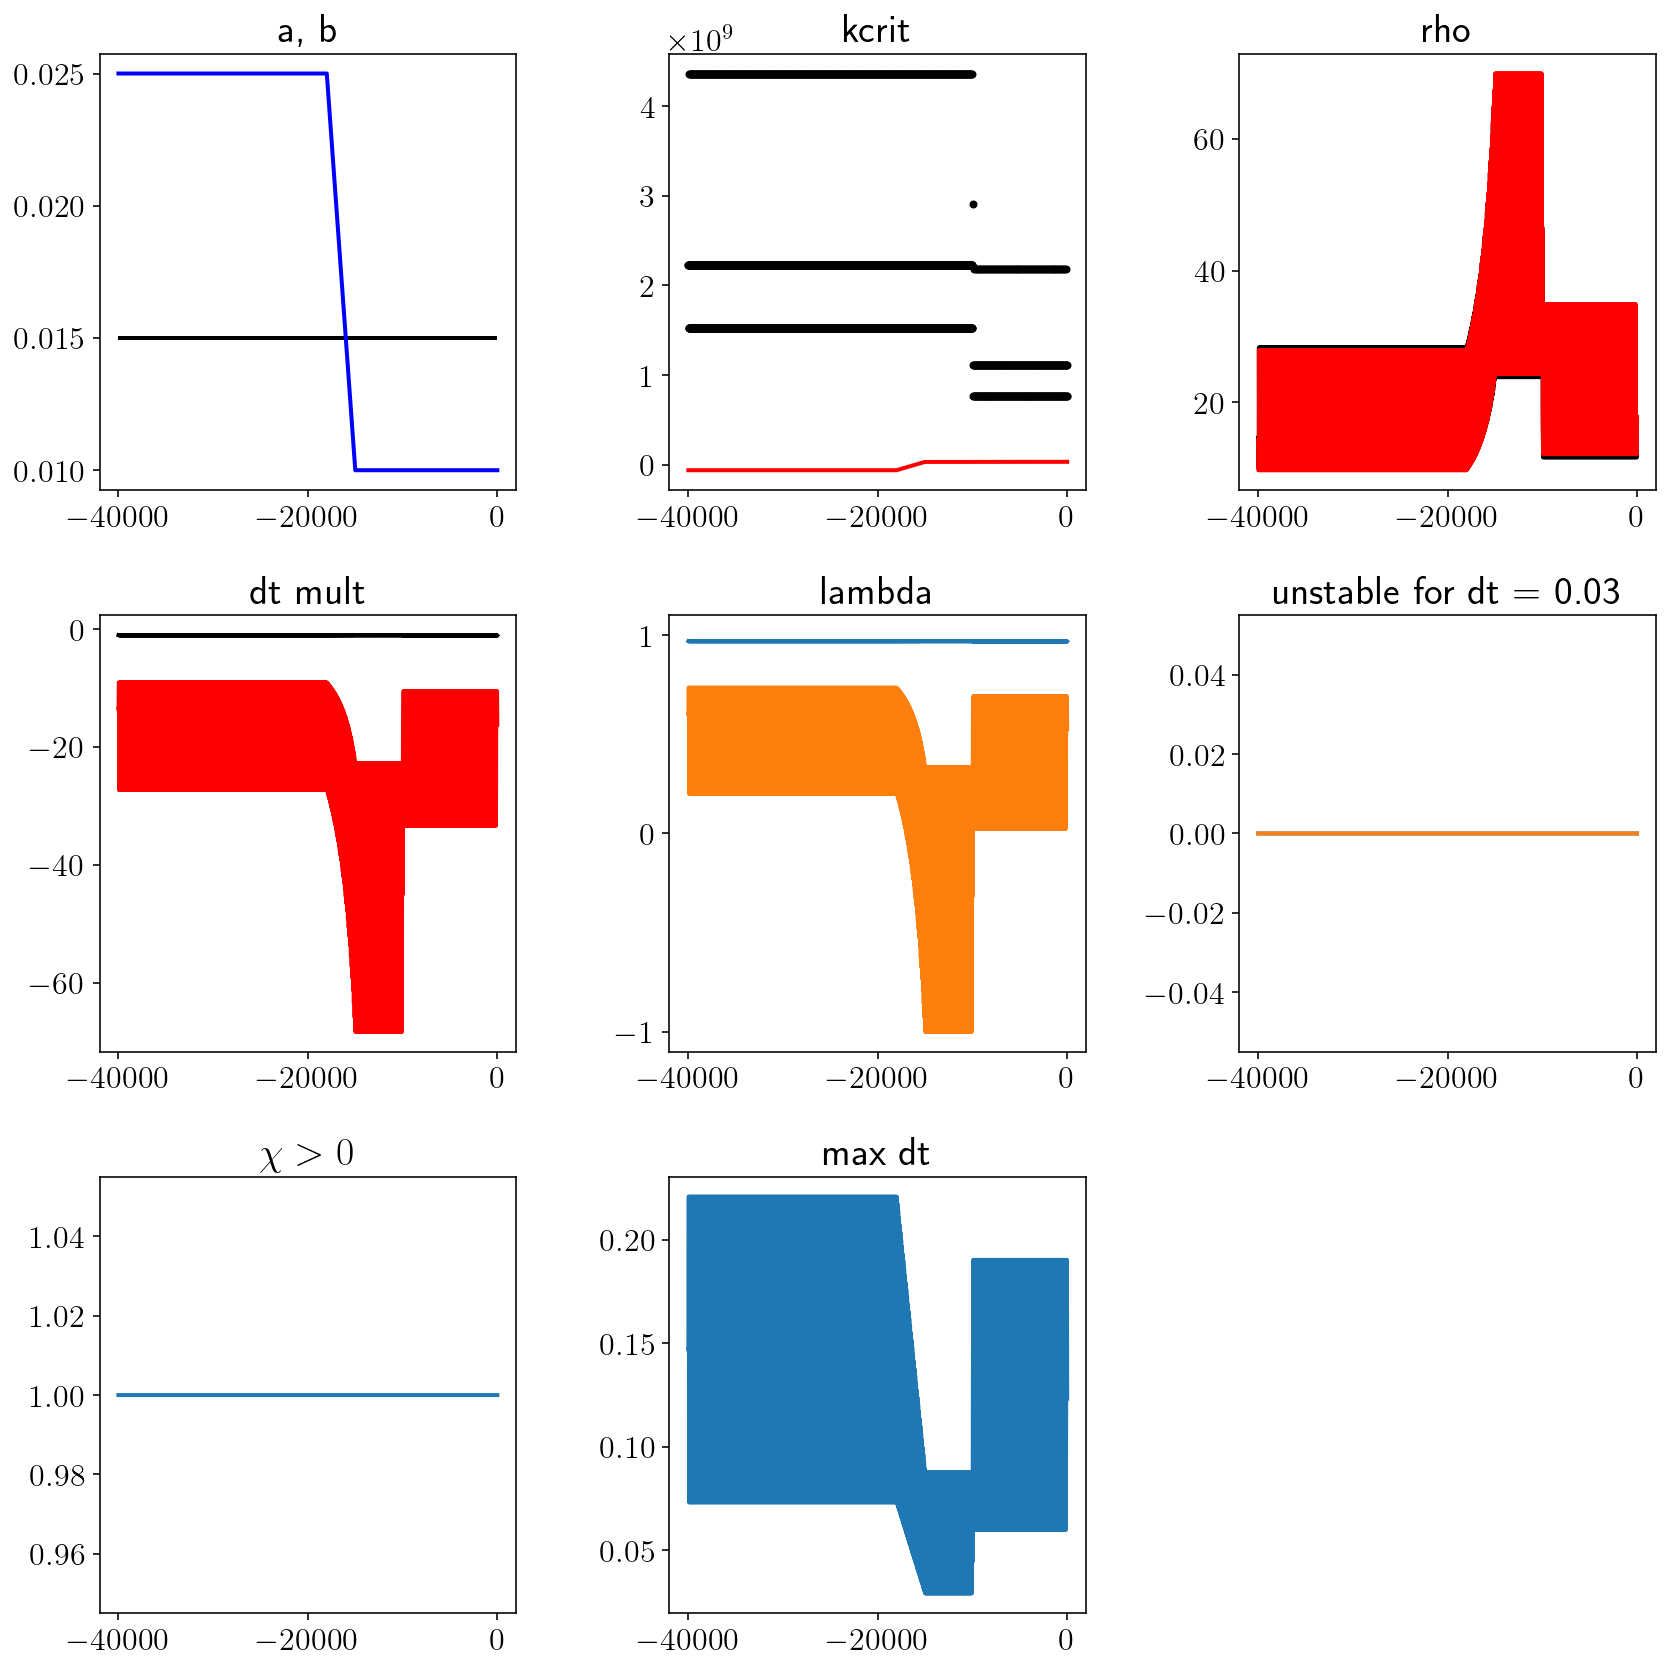

In [230]:
h = np.abs(np.concatenate((fy[1:] - fy[:-1], fy[-1:] - fy[-2:-1])))
# h = np.repeat(fault.panel_length, fault.panel_order)
# k could be calculated empirically! I'm just guessing here.
k = 1.0 * shear_modulus / h
Astar = sigma_n * fp.a
Bstar = sigma_n * fp.b
kcr = (Bstar - Astar) / fp.Dc
rho = fp.Dc / Astar * (k - kcr)
chi = 0.25 * rho ** 2 - k * fp.Dc / Astar
max_dt_ratio = np.where(chi > 0,
    # Astar / ((k - kcr) * fp.Dc),
    2 / (0.5 * rho + np.sqrt(chi)),
    2 / (0.5 * rho),
    # (1 - kcr / k)
)

mult1 = -0.5 * rho + np.sqrt(chi + 0j)
mult2 = -0.5 * rho - np.sqrt(chi + 0j)
dt = np.min(max_dt_ratio)
lambda1 = 1 + mult1 * dt
lambda2 = 1 + mult2 * dt

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.title('a, b')
plt.plot(fy, fp.a, 'b-')
plt.hlines([fp.b], np.min(fy), np.max(fy), color='k')
plt.subplot(3, 3, 2)
plt.title('kcrit')
plt.plot(fy, k, 'k.')
plt.plot(fy, kcr, 'r-')
plt.subplot(3, 3, 3)
plt.title('rho')
plt.plot(fy, rho, 'k-')
plt.plot(fy, k * fp.Dc / Astar, 'r-')
# plt.plot(fy, np.abs(lambda1))
# plt.plot(fy, np.abs(lambda2))
# plt.show()
# plt.plot(fy, np.imag(lambda1))
# plt.plot(fy, np.imag(lambda2))
# plt.show()
plt.subplot(3, 3, 4)
plt.title('dt mult')
plt.plot(fy, mult1, 'k-')
plt.plot(fy, mult2, 'r-')
plt.subplot(3, 3, 5)
plt.title('lambda')
plt.plot(fy, np.real(lambda1))
plt.plot(fy, np.real(lambda2))
plt.ylim([-1.1, 1.1])
plt.yticks([-1, 0, 1])
plt.subplot(3, 3, 6)
plt.title(f'unstable for dt = {dt:.2f}')
plt.plot(fy, np.abs(np.real(lambda1)) > 1.0)
plt.plot(fy, np.abs(np.real(lambda2)) > 1.0)
plt.subplot(3,3,7)
plt.title('$\chi>0$')
plt.plot(fy, chi>0)
plt.subplot(3,3,8)
plt.title('max dt')
plt.plot(fy, max_dt_ratio)
plt.tight_layout()
plt.show()

In [50]:
calc_system_state.V_old = np.full(fault.n_pts, Vp)
max_T = 3000 * siay


n_steps = 300001
fy = fault.pts[:,1]
t = 0
y = init_conditions.copy()
t_history = []
y_history = []
for i in range(n_steps):
    t_history.append(t)
    y_history.append(y.copy())

    state0 = calc_system_state(t, y)
    _, _, _, v0, sdr0, dstatedt0 = state0
    yd0 = np.concatenate((sdr0, dstatedt0))
    dt = np.min(0.125 * fp.Dc / v0)
    y1 = y + 0.5 * dt * yd0
    t1 = t + 0.5 * dt

    state1 = calc_system_state(t1, y1)
    _, _, _, v1, sdr1, dstatedt1 = state1
    yd1 = np.concatenate((sdr1, dstatedt1))
    # print(np.max(v1), t, dt / siay, dt)
    y += yd1 * dt

    if i % 1000 == 0:
        print(f"step={i}, time={t / siay} yrs")
        print(np.max(v1), dt)

    t += dt
    if t > max_T:
        break

step=0, time=196.52530487880088 yrs
0.39136147783565367 0.0032996265250858463
step=1000, time=196.52530499586905 yrs
0.09430749371009692 0.004380487111717049
step=2000, time=196.52530533380497 yrs
0.00862018638298044 0.033210292110077325
step=3000, time=196.52532202468137 yrs
0.00018171015097366583 2.0329834488395107
step=4000, time=196.52593292243833 yrs
7.482855264058095e-06 65.27334756189485
step=5000, time=196.53692870957215 yrs
5.717374617735327e-07 941.1356920744806
step=6000, time=196.63545167014695 yrs
6.765676905569598e-08 6805.472948582062
step=7000, time=197.13334113389 yrs
1.0528954250228334e-08 28496.945374819617
step=8000, time=198.76429891373778 yrs
4.022999802370682e-09 80669.9691632718
step=9000, time=202.67376837233775 yrs
1.9920850276533187e-09 173211.6921885901
step=10000, time=210.12875909529856 yrs
1.1892610498219742e-09 301062.4361308729
step=11000, time=219.59868548246334 yrs
9.976368111488794e-10 97020.21633178573
step=12000, time=222.6765803286621 yrs
9.969476

KeyboardInterrupt: 

In [97]:
from scipy.integrate import RK23, RK45

calc_system_state.V_old = np.full(fault.n_pts, Vp)

atol = Vp * 1e-8
rtol = 1e-5
rk = RK45(calc_derivatives, 0, init_conditions, 1e50, atol=atol, rtol=rtol)
rk.h_abs = 60 * 60 * 24

# n_steps = 100000
max_T = 3000 * siay

t_history = [0]
y_history = [init_conditions.copy()]

n_steps = 25000
for i in range(n_steps):
    if rk.step() != None:
        raise Exception("TIME STEPPING FAILED")
        break

    if i % 1000 == 0:
        print(f"step={i}, time={rk.t / siay} yrs")
        # plot_system_state(calc_derivatives.state)

    t_history.append(rk.t)
    y_history.append(rk.y.copy())

    if rk.t > max_T:
        break

step=0, time=0.002737907006988508 yrs
step=1000, time=19.760595261630037 yrs
step=2000, time=36.16335479706496 yrs
step=3000, time=50.55555330969491 yrs
step=4000, time=65.61585328634628 yrs
step=5000, time=80.92364399365346 yrs
step=6000, time=96.1352640916242 yrs
step=7000, time=111.26353927450978 yrs
step=8000, time=126.39740244948852 yrs
step=9000, time=141.4585748398158 yrs
step=10000, time=156.23779493986436 yrs
step=11000, time=171.17585886013163 yrs
step=12000, time=185.81256241994984 yrs
step=13000, time=196.52448268527812 yrs
step=14000, time=196.52537405174155 yrs
step=15000, time=196.52537418181296 yrs
step=16000, time=196.5253743630789 yrs
step=17000, time=196.52537459710234 yrs
step=18000, time=196.52537477562652 yrs
step=19000, time=196.52537543184243 yrs
step=20000, time=196.52610604881522 yrs
step=21000, time=196.5746568971615 yrs
step=22000, time=198.4787177115463 yrs
step=23000, time=211.05069464281664 yrs
step=24000, time=225.32966748824765 yrs


In [98]:
rk.t / siay

240.09591380168882

In [52]:
y_history = np.array(y_history)
t_history = np.array(t_history)

## Plotting the results

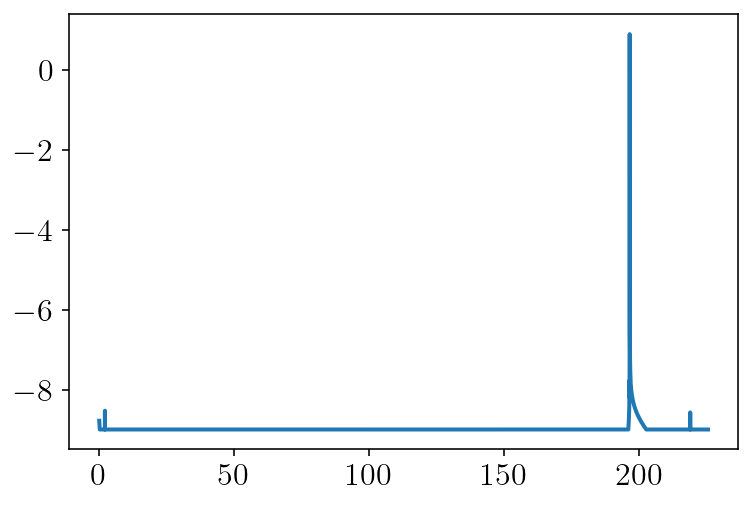

In [53]:
derivs_history = np.diff(y_history, axis=0) / np.diff(t_history)[:, None]
max_vel = np.max(np.abs(derivs_history), axis=1)
plt.plot(t_history[1:] / siay, np.log10(max_vel))
plt.show()

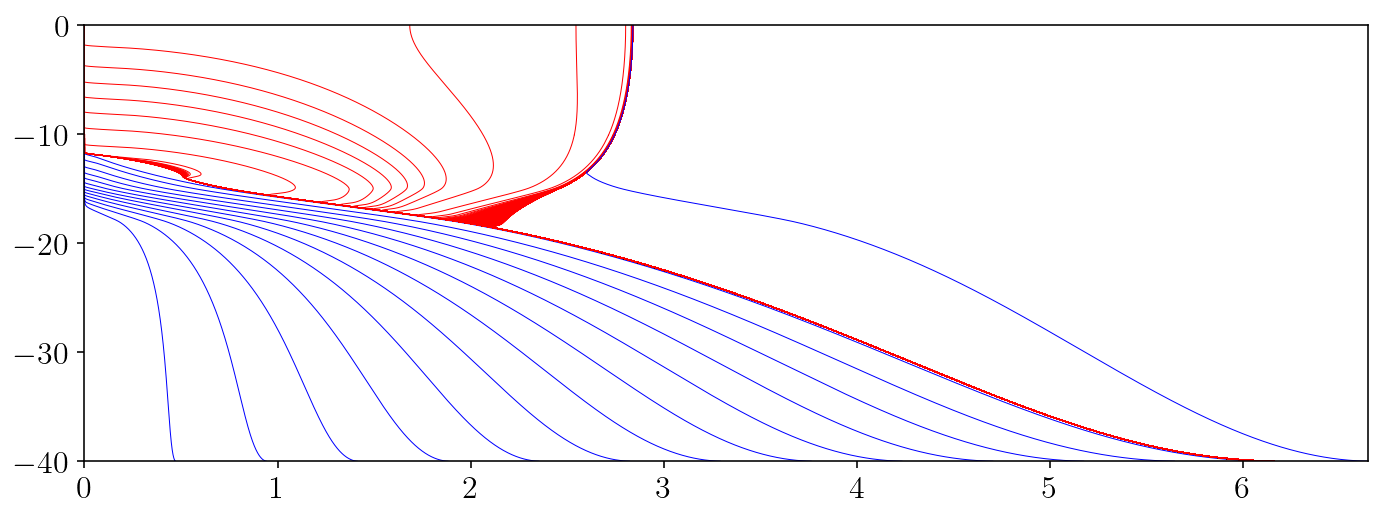

In [54]:
plt.figure(figsize=(10, 4))
last_plt_t = -1000
last_plt_slip = init_slip_deficit
event_times = []
for i in range(len(y_history) - 1):
    y = y_history[i]
    t = t_history[i]
    slip_deficit = y[: init_slip_deficit.shape[0]]
    should_plot = False
    if (
        max_vel[i] >= 0.0001 and t - last_plt_t > 3
    ):  # np.max(np.abs(slip - last_plt_slip)) > 0.25:
        if len(event_times) == 0 or t - event_times[-1] > siay:
            event_times.append(t)
        should_plot = True
        color = "r"
    if t - last_plt_t > 15 * siay:
        should_plot = True
        color = "b"
    if should_plot:
        slip = -slip_deficit + Vp * t
        plt.plot(slip, fy / 1000.0, color + "-", linewidth=0.5)
        last_plt_t = t
        last_plt_slip = slip
plt.xlim([0, np.max(last_plt_slip)])
plt.ylim([-40, 0])
# plt.ylabel(r"$\textrm{z (km)}$")
# plt.xlabel(r"$\textrm{slip (m)}$")
plt.tight_layout()
plt.savefig("halfspace.png", dpi=300)
plt.show()

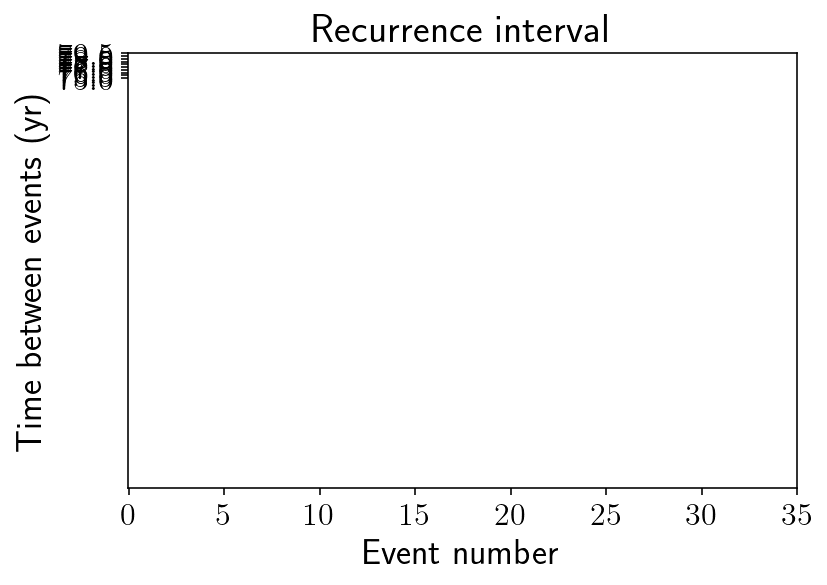

In [55]:
plt.title("Recurrence interval")
plt.plot(np.diff(event_times) / siay, "k-*")
plt.xticks(np.arange(0, 36, 5))
plt.yticks(np.arange(75, 80, 0.5))
plt.xlabel("Event number")
plt.ylabel("Time between events (yr)")
plt.show()

In [57]:
t_idx = 80000  # np.argmax((t_history > event_times[0] - 10))
fault_idx = np.argmax((-7480 > fy) & (fy > -7500))
n_steps = 30000
t_chunk = t_history[t_idx : (t_idx + n_steps)]
y_chunk = y_history[t_idx : (t_idx + n_steps)]
shear_chunk = []
slip_rate_chunk = []
slip_deficit_chunk = []
for i in range(n_steps):
    system_state = calc_system_state(t_history[t_idx + i], y_history[t_idx + i])
    slip_deficit, state, tau_qs, V, slip_deficit_rate, dstatedt = system_state
    slip_deficit_chunk.append(slip_deficit)
    shear_chunk.append((tau_qs - eta * V))
    slip_rate_chunk.append(V)

shear_chunk = np.array(shear_chunk)
slip_rate_chunk = np.array(slip_rate_chunk)
slip_deficit_chunk = np.array(slip_deficit_chunk)

In [58]:
t_start = t_chunk[np.argmax(slip_rate_chunk[:,fault_idx] > 0.1)]

In [59]:
jiang_data = np.loadtxt("jiang.txt")
jiang_vel = np.diff(jiang_data[:, 1]) / np.diff(jiang_data[:, 0])
jiang_t_start = np.argmax(jiang_vel > 0.1)

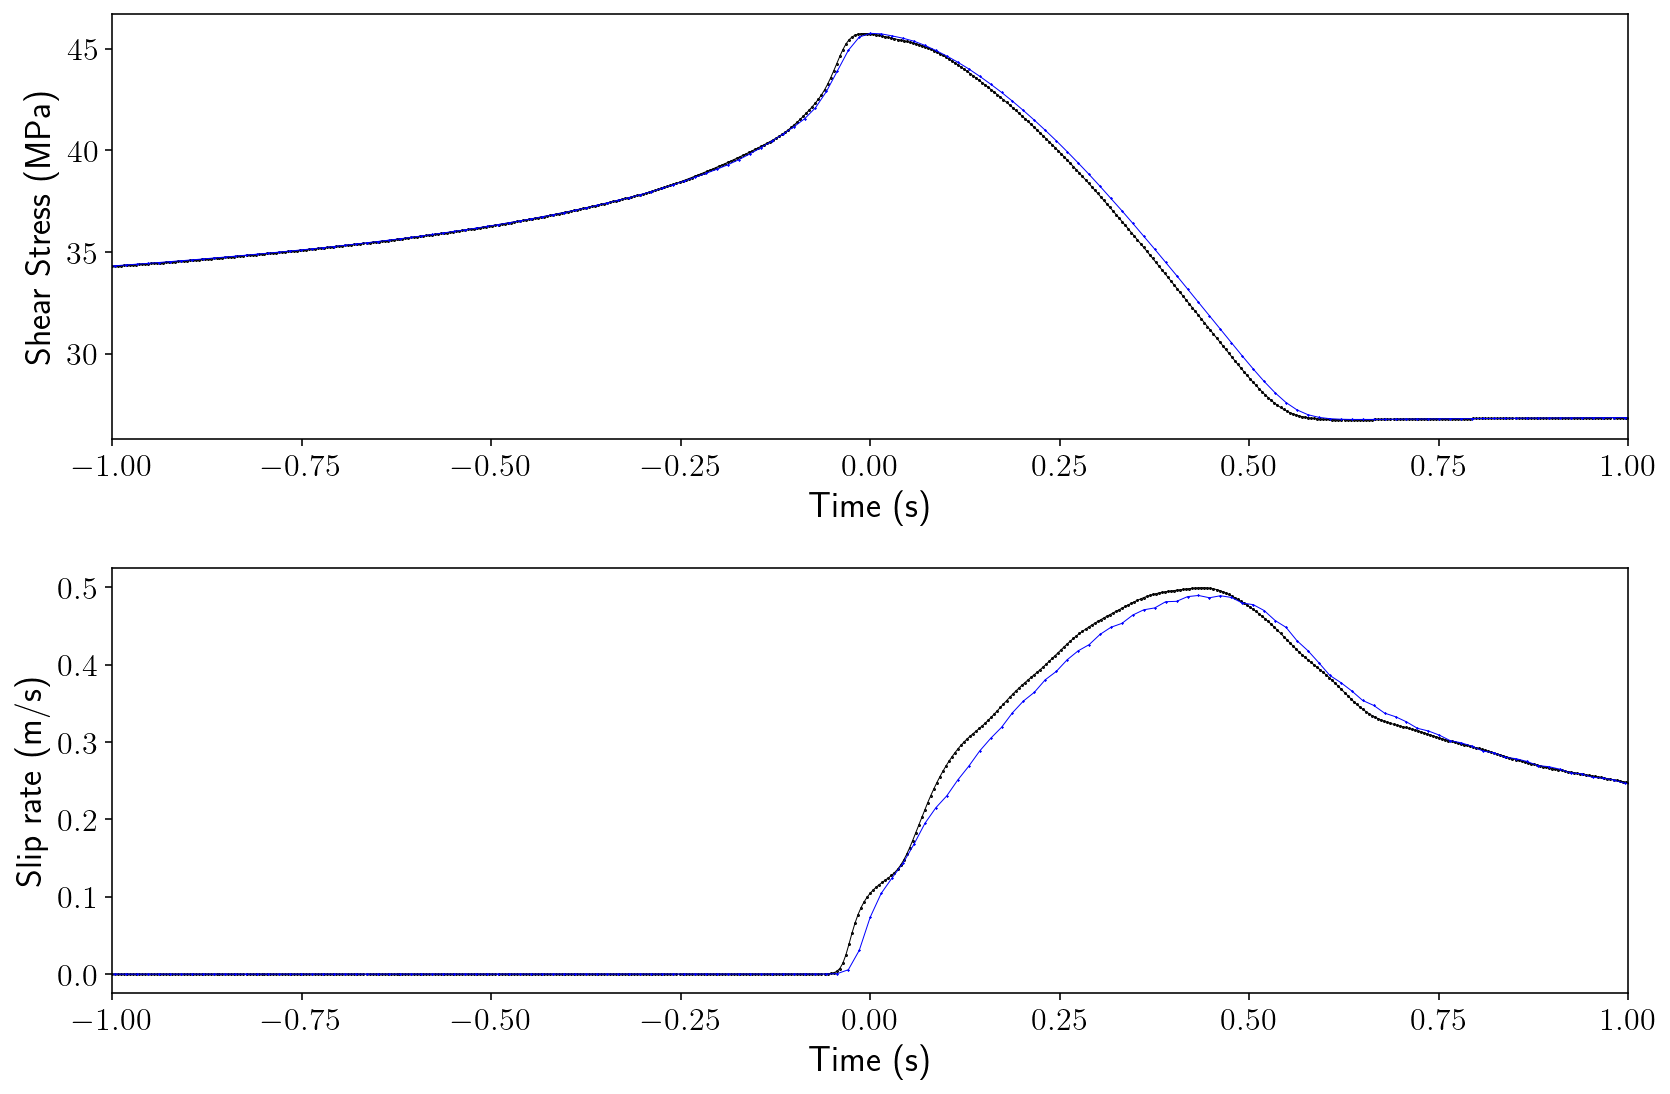

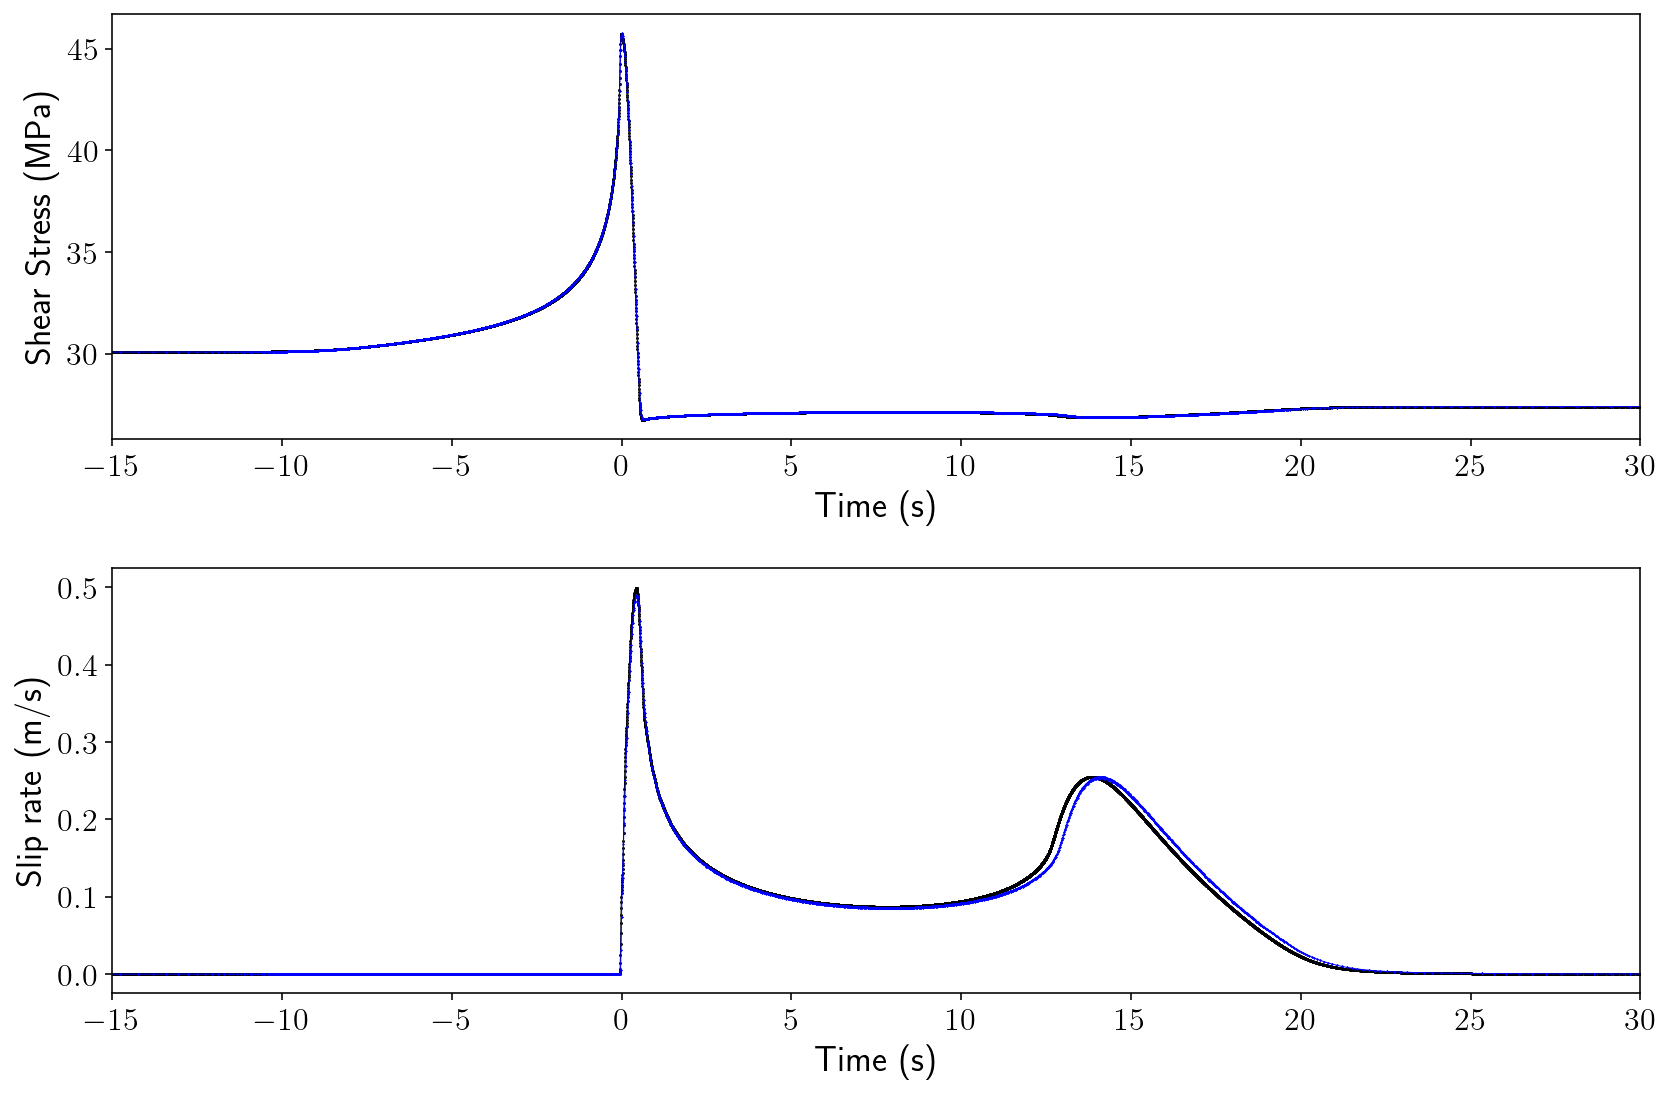

In [60]:
for lims in [(-1, 1), (-15, 30)]:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t_chunk - t_start, shear_chunk[:,fault_idx] / 1e6, "k-o", markersize=0.5, linewidth=0.5)
    plt.plot(
        jiang_data[:, 0] - jiang_data[jiang_t_start, 0],
        jiang_data[:, 3],
        "b-*",
        markersize=0.5,
        linewidth=0.5,
    )
    plt.xlim(lims)
    plt.xlabel("Time (s)")
    plt.ylabel("Shear Stress (MPa)")
    # plt.show()

    plt.subplot(2, 1, 2)
    plt.plot(t_chunk - t_start, slip_rate_chunk[:,fault_idx], "k-o", markersize=0.5, linewidth=0.5)
    plt.plot(
        jiang_data[1:, 0] - jiang_data[jiang_t_start, 0],
        jiang_vel[:],
        "b-*",
        markersize=0.5,
        linewidth=0.5,
    )
    plt.xlim(lims)
    plt.xlabel("Time (s)")
    plt.ylabel("Slip rate (m/s)")
    plt.tight_layout()
    plt.show()

In [40]:
shear_chunk.shape

(12000, 1536)

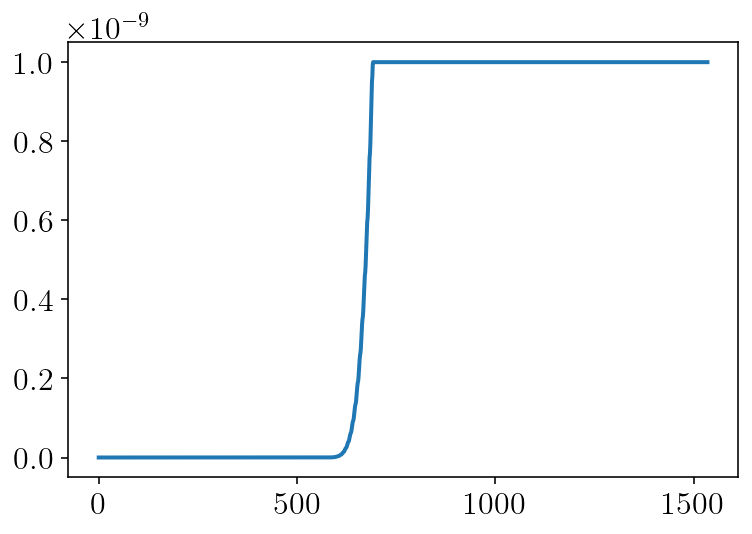

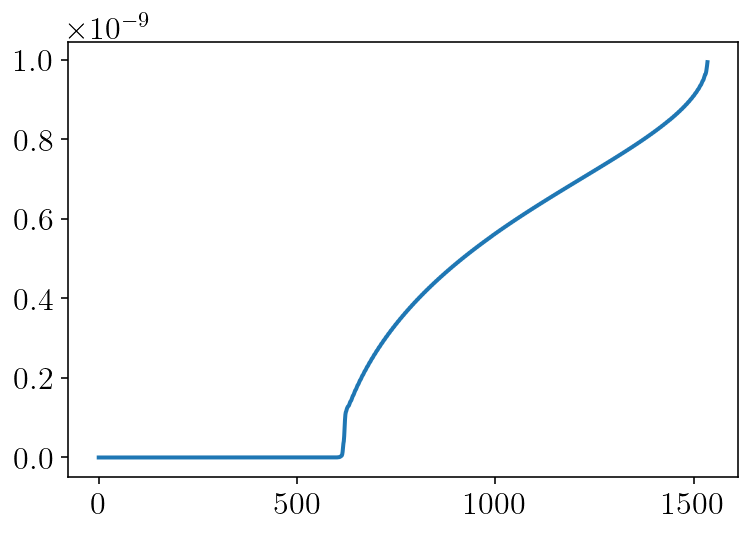

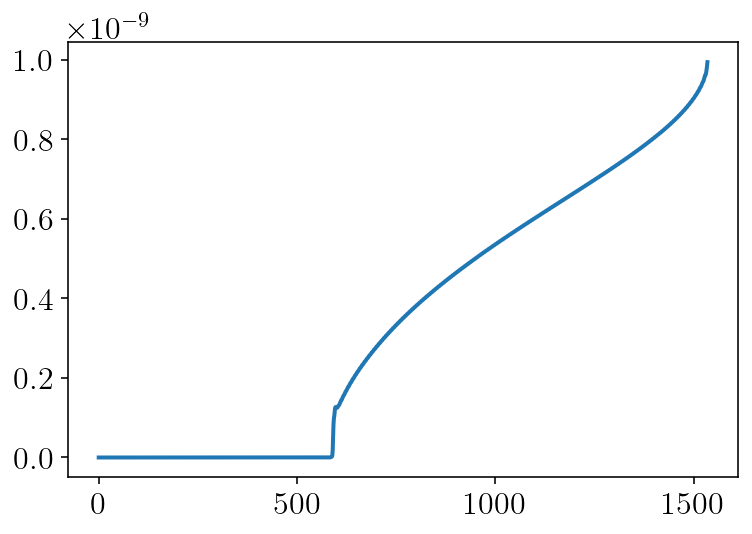

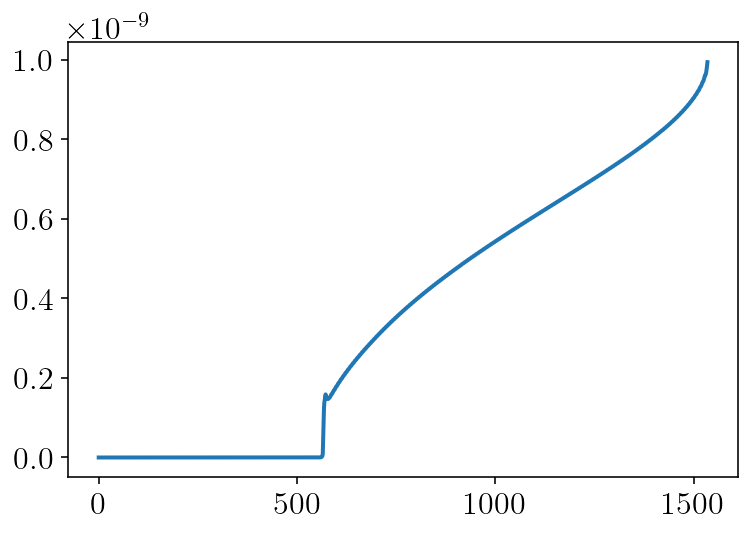

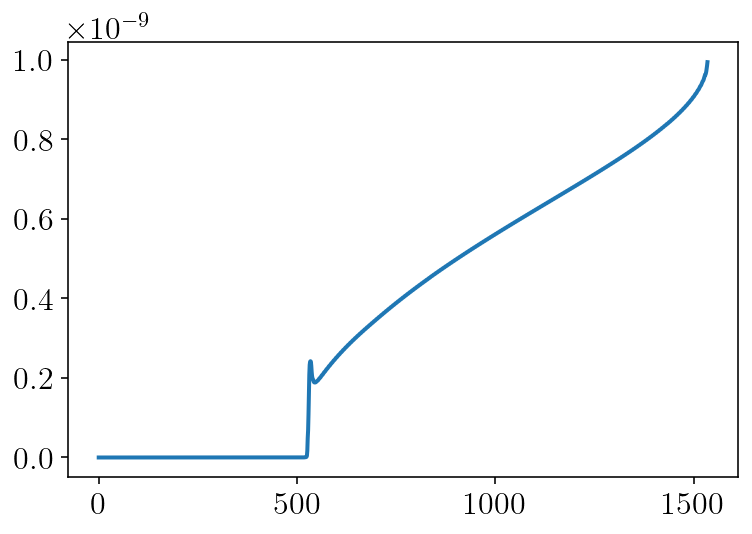

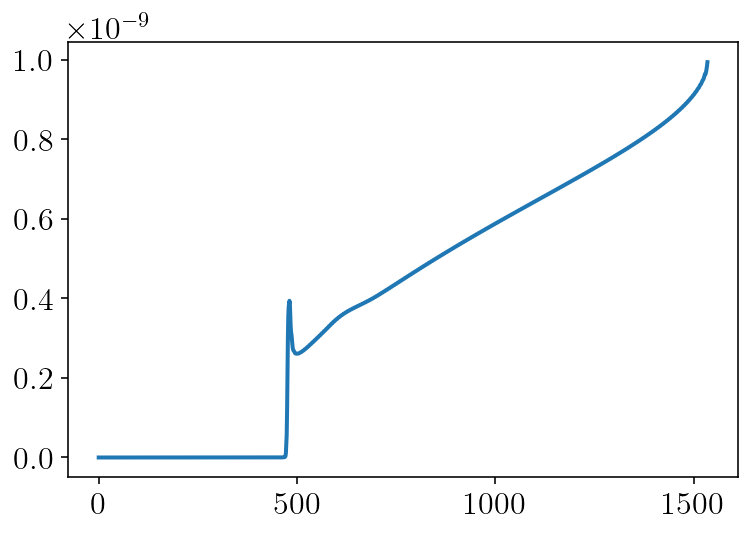

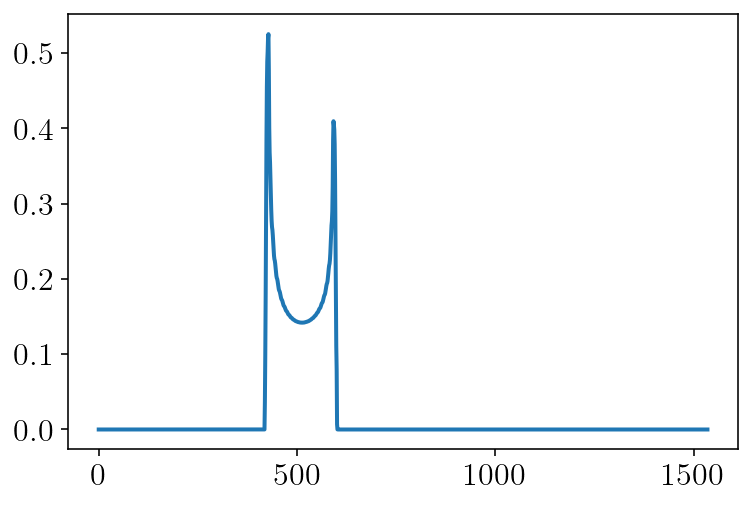

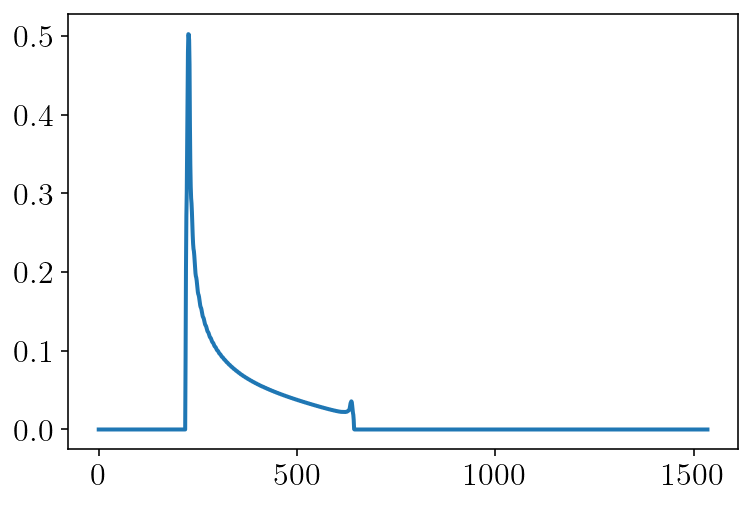

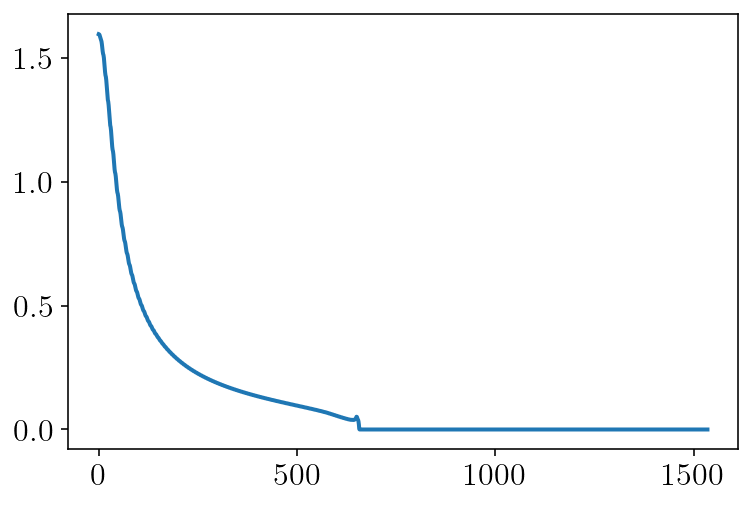

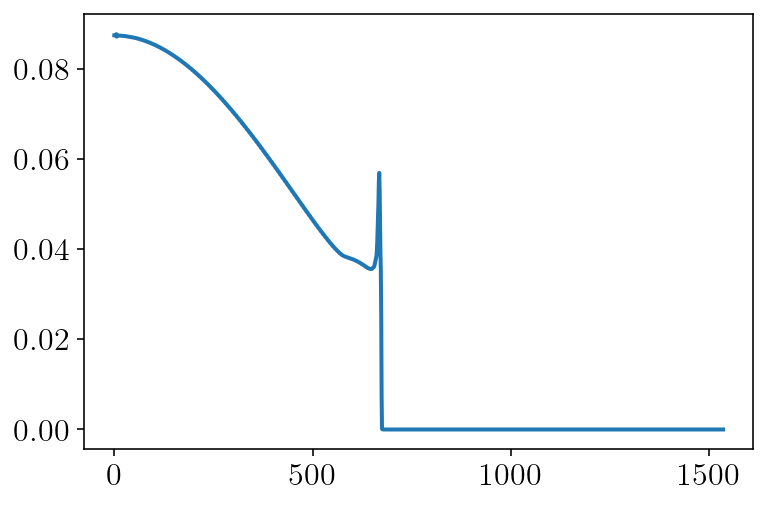

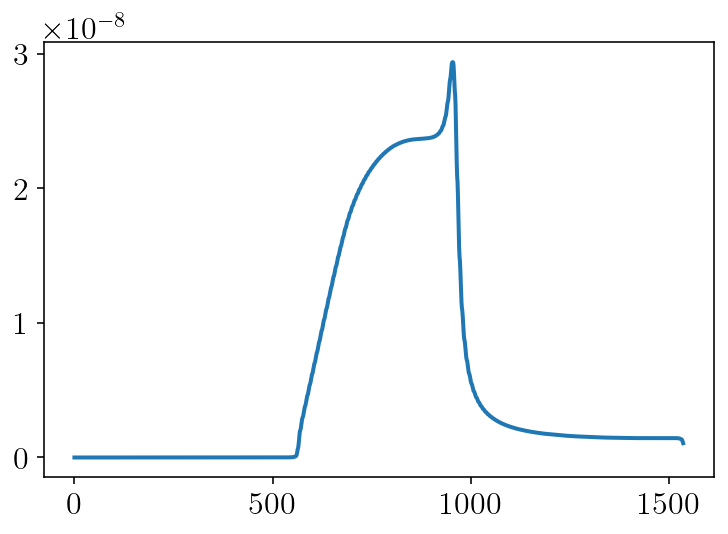

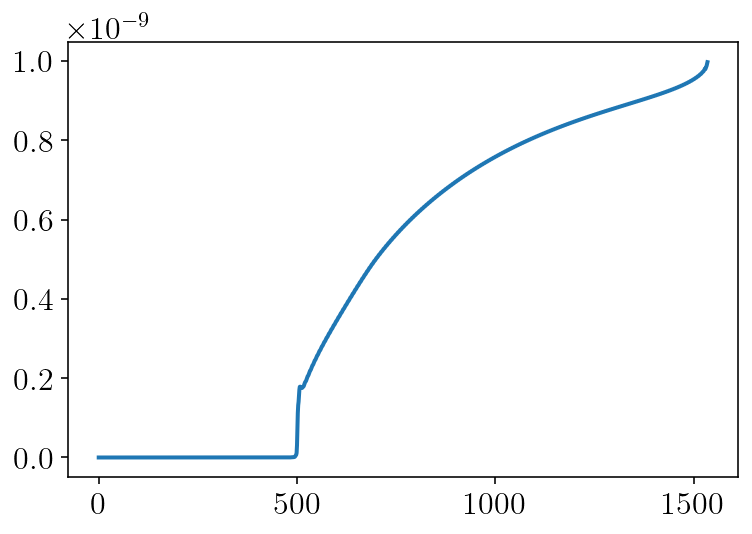

In [41]:
for i in range(0, 12000, 1000):
    plt.plot(
        slip_rate_chunk[
            i,
        ]
    )
    plt.show()

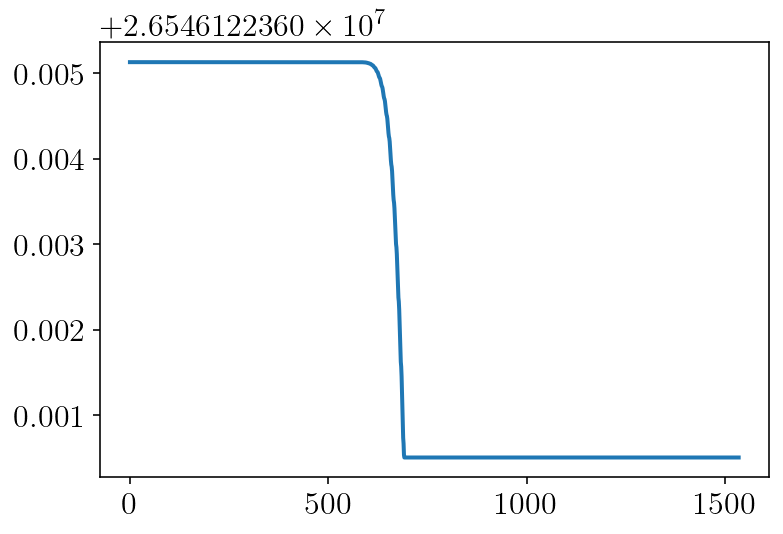

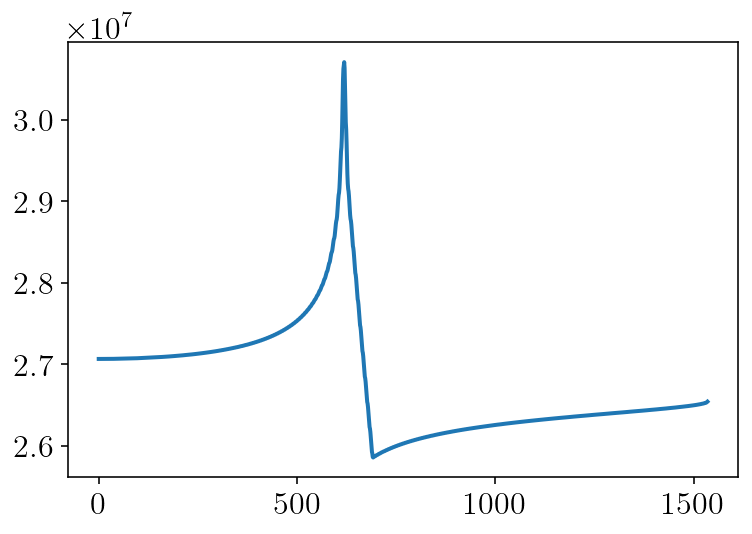

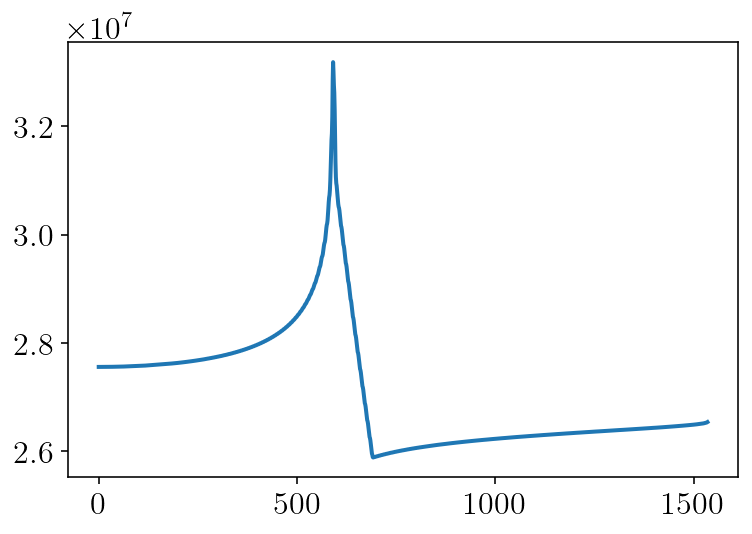

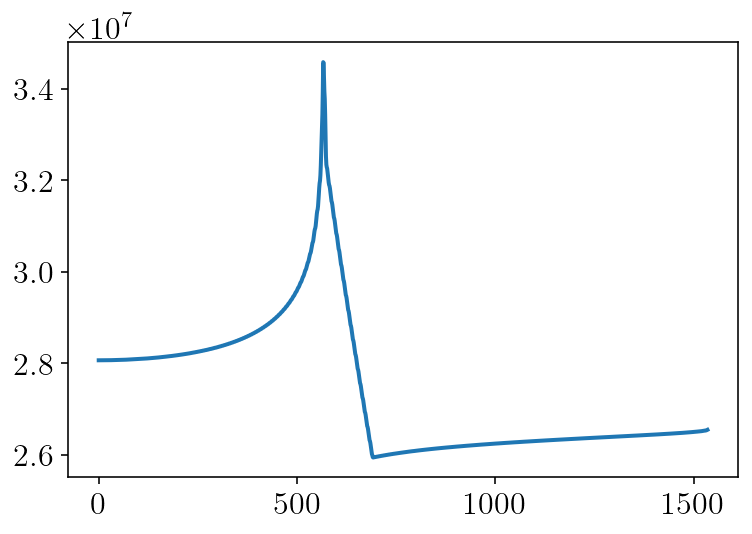

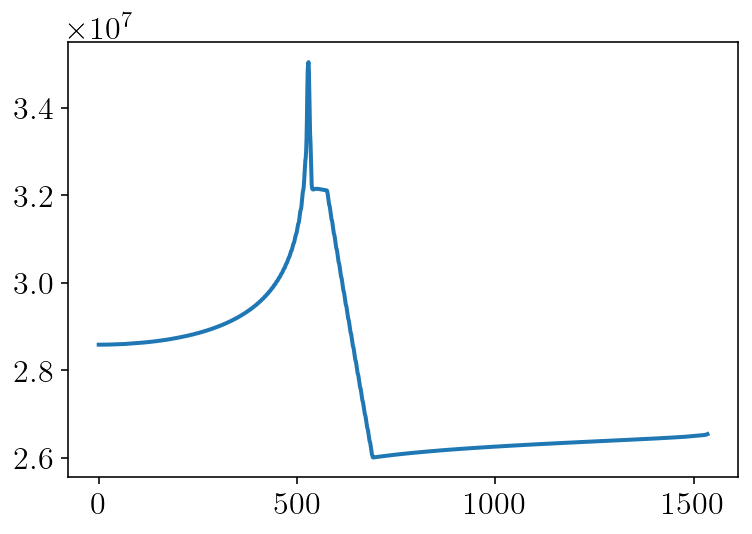

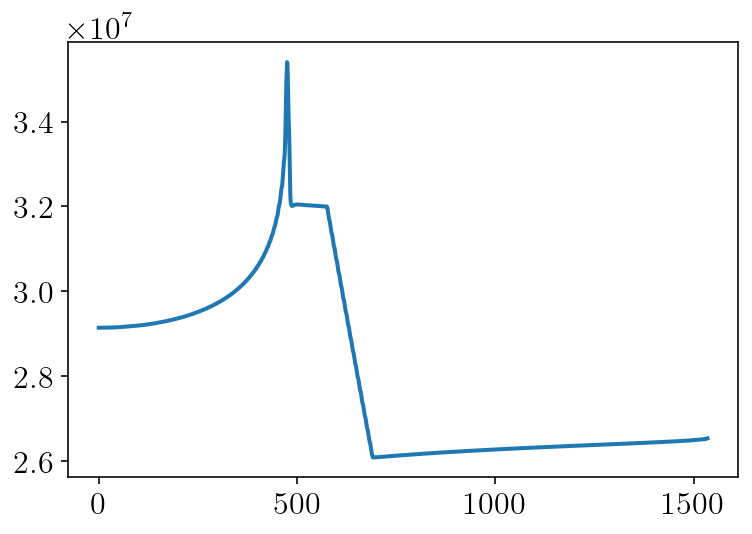

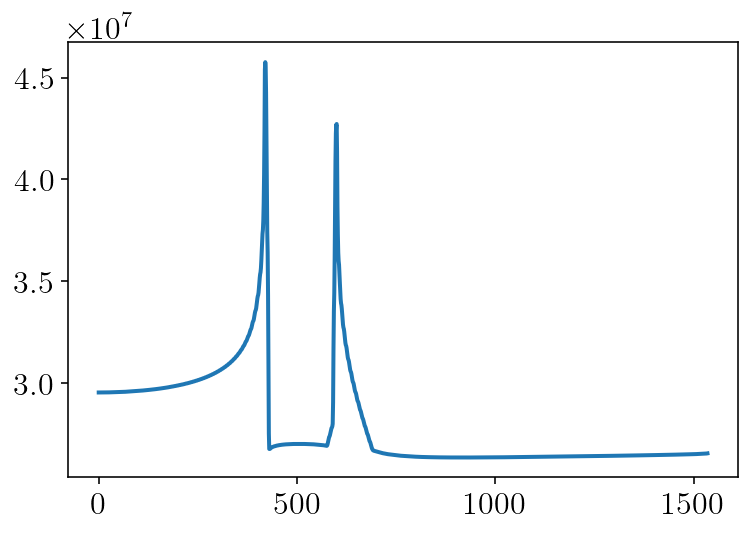

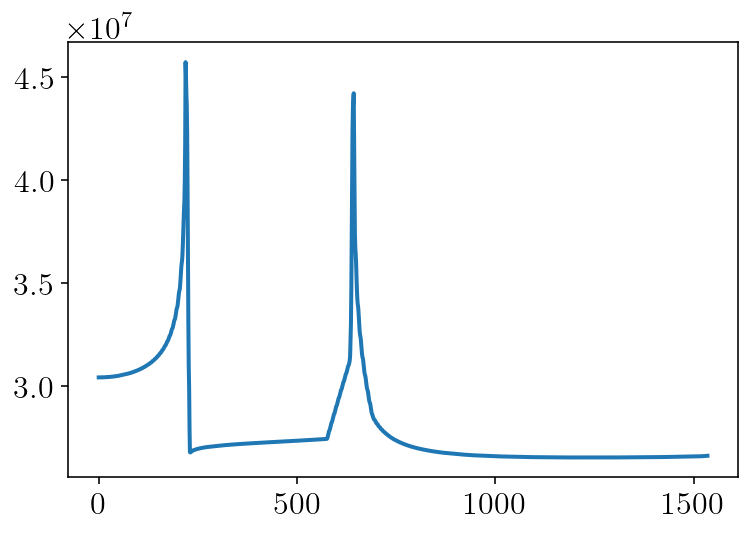

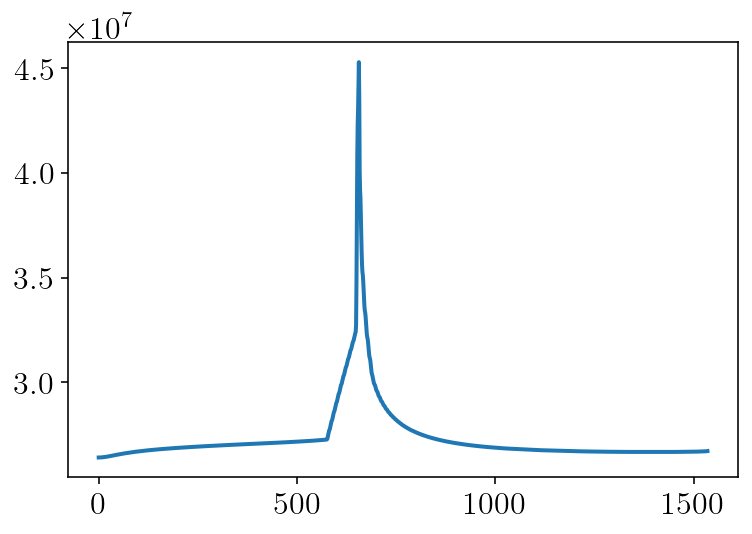

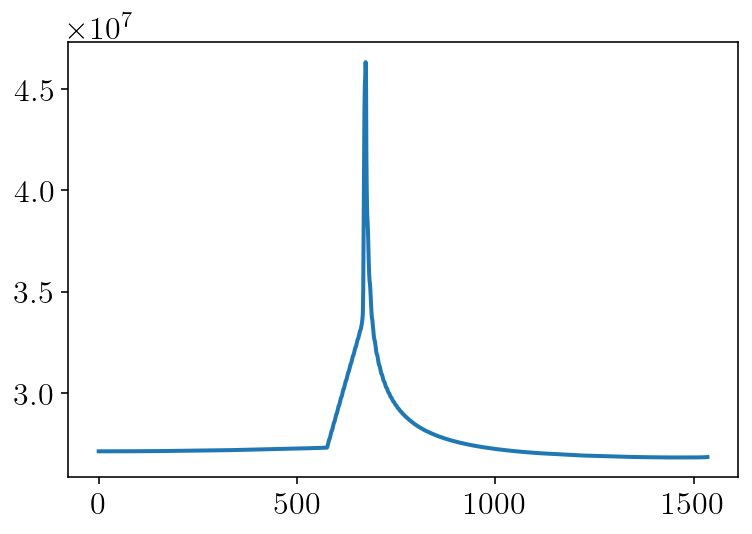

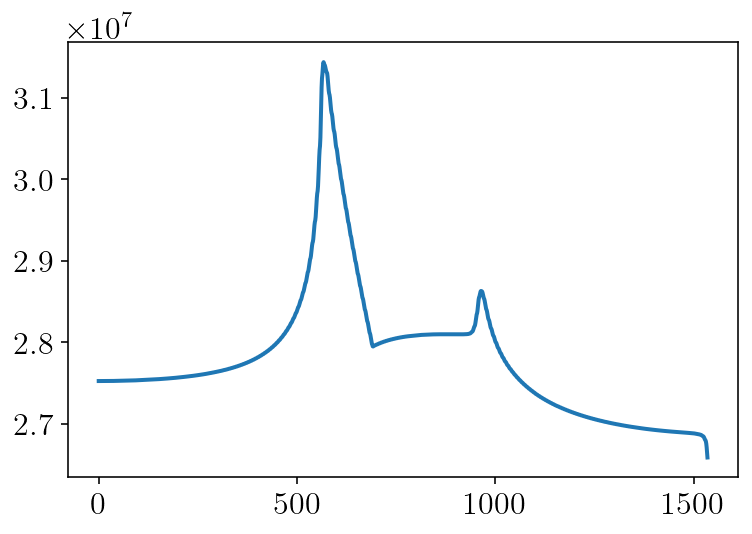

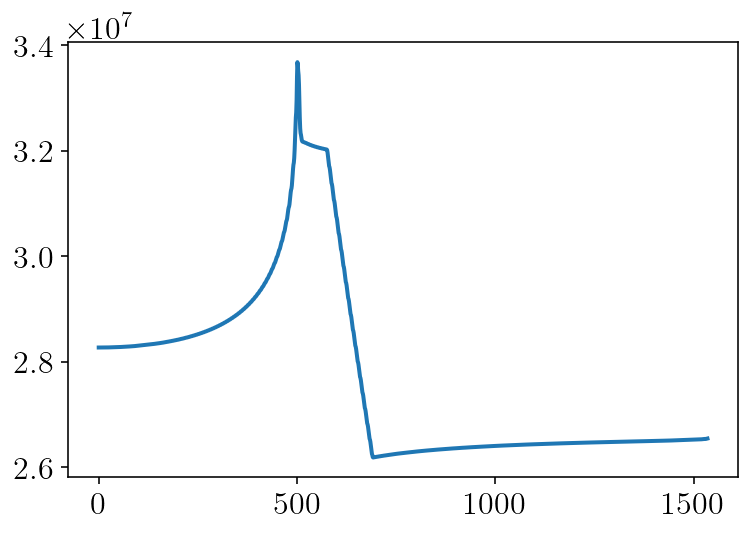

In [42]:
for i in range(0, 12000, 1000):
    plt.plot(
        shear_chunk[
            i,
        ]
    )
    plt.show()

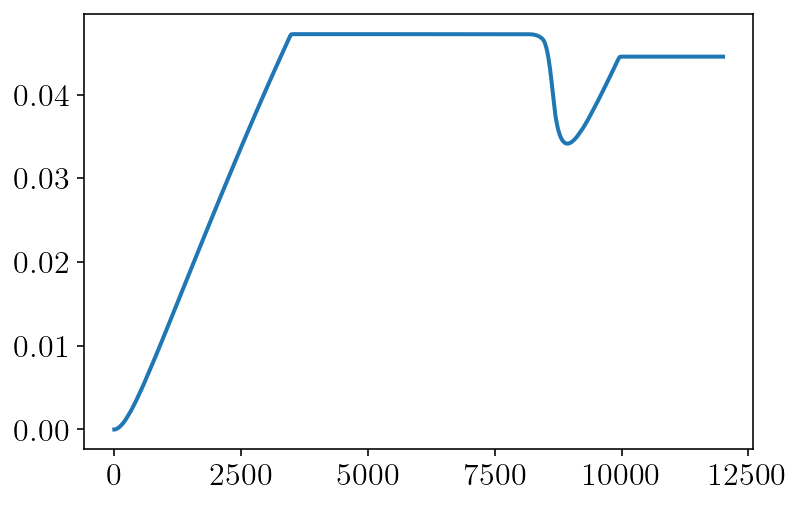

In [ ]:
plt.plot(Vp * t_history - y_history[:, fault.n_pts - 1])
plt.show()